## Importing Libraries

In [274]:
import pandas as pd
import numpy as np
import geopandas as gpd


import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
import geog

import folium
import geopy.distance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from descartes import PolygonPatch
import altair as alt

import folium

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

import warnings
warnings.filterwarnings('ignore')

## Defining Consts

In [2]:
### Consts
datapath = '../rawdata/sensors/'
sensors_file = datapath + 'nodes.txt'

## Loading External Datasets

In [3]:
## loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')
noiseComplaints = gpd.GeoDataFrame(noiseComplaints, crs={'init' : 'epsg:4326'}, geometry='geometry')

## loading taxi
taxi = pd.read_pickle('../data/taxi/taxi.pkl')

## loading wind speed
windSpeed = pd.read_pickle('../data/weather/wind.pkl')
windSpeed = windSpeed.resample('H').agg({'Spd[Wind]': 'mean'})

## loading precipitation
precipitation = pd.read_pickle('../data/weather/precipitation.pkl')
precipitation = precipitation.resample('H').agg({'Amt[PrecipHourly1]': 'mean'})

## Loading Assets

In [5]:
# loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')
taxi_regions = taxi_regions.to_crs({'init':'epsg:3857'}) 

## Calculating Temporal Intersection

In [6]:
noiseComplaints_start, noiseComplaints_end = noiseComplaints.index[0], noiseComplaints.index[-1]
taxi_start, taxi_end = taxi.index[0], taxi.index[-1]
windSpeed_start, windSpeed_end = windSpeed.index[0], windSpeed.index[-1]
precipitation_start, precipitation_end = precipitation.index[0], precipitation.index[-1]

## Calculating the largest intersection
intersection_start = max(noiseComplaints_start, taxi_start, windSpeed_start, precipitation_start)
intersection_end = min(noiseComplaints_end, taxi_end, windSpeed_end, precipitation_end)

print('311 Range: ', noiseComplaints_start, '----', noiseComplaints_end)
print('Taxi Range: ', taxi_start, '----', taxi_end)
print('Wind Speed Range: ', windSpeed_start,'----', windSpeed_end)
print('Rain Precipitation Range: ', precipitation_start,'----', precipitation_end)
print('Largest Intersection: ', intersection_start,'----', intersection_end)

311 Range:  2010-01-01 00:03:46 ---- 2019-01-28 02:11:59
Taxi Range:  2017-01-01 00:00:00 ---- 2018-07-01 23:46:41
Wind Speed Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Rain Precipitation Range:  2010-01-01 01:00:00 ---- 2018-04-02 00:00:00
Largest Intersection:  2017-01-01 00:00:00 ---- 2018-04-02 00:00:00


## Sensors in Manhattan

In [108]:
sensors_geodf = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})

f = open(sensors_file)
for line in f:
    s, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    ## adding sensor to geodataframe
    sensor_point = shapely.geometry.Point(lon, lat)
    sensors_geodf = sensors_geodf.append({'sensorID': s, 'geometry':sensor_point}, ignore_index=True)
    
    
sensors_geodf = sensors_geodf.to_crs({'init':'epsg:3857'})

## join taxi regions with sensors
manhattan_regions = taxi_regions[taxi_regions['borough'] == 'Manhattan']
manhattan_sensors = gpd.tools.sjoin(sensors_geodf, manhattan_regions, how='inner', op="within")

## closing file
f.close()

## Aggregating by Location

In [ ]:
## check it out what is happening with these sensors
problematicSensors = ['sonycnode-b827eb74a9e8.sonyc', 'sonycnode-b827ebed47a6.sonyc', 'sonycnode-b827eb18a94a.sonyc']

## saving time series by location
timeseries = {}

## filtering locations with sensors
locations_with_sensors = manhattan_sensors['LocationID'].unique()

for location in locations_with_sensors:
    
    print('Location: ', location)
    
    ## getting sensors within location
    currentSensors = manhattan_sensors[manhattan_sensors['LocationID'] == location]['sensorID'].values
    
    ## initializing dict row
    timeseries[location] = {}
    
    f = open(sensors_file)
    for line in f:
        
        s, lat, lon = line.split(' ')
        lat = float(lat)
        lon = float(lon)
        
        if( (s in currentSensors) and (not(s in problematicSensors)) ):
            
            print('\tsensor:', s)

            # loading sensor data
            sensorData = pd.read_pickle(datapath +s+ '.pkl')
            
            # calculating the intersection with the external datasets
            sensorData_start, sensorData_end = sensorData.index[0], sensorData.index[-1]
            dataframe_start, dataframe_end = max(sensorData_start, intersection_start), min(sensorData_end, intersection_end)
    
            # creating empty timeseries
            df_timeseries = pd.DataFrame()
            df_timeseries['datetime'] = pd.date_range(dataframe_start, dataframe_end, freq="1h")
            df_timeseries.set_index(['datetime'], inplace = True)
            
            # calculating the average over one hour of SPL
            sensorData['dbas'] = sensorData['sum'] / sensorData['count']
            
            # adding sensor data to the empty dataframe
            df_timeseries['dbas'] = sensorData['dbas'][dataframe_start:dataframe_end]
            
            # adding wind speed to the dataframe
            df_timeseries['wind'] = windSpeed[dataframe_start:dataframe_end]
        
            # adding rain precipitation to the dataframe
            df_timeseries['precipitation'] = precipitation[dataframe_start:dataframe_end]

            # adding taxi data to the empty dataframe
            taxi_temp = taxi[taxi['location'] == location]
            taxi_temp = taxi_temp.resample('H').agg({'location': 'count'})
            taxi_temp.rename({'location':'trips'}, inplace=True)
            df_timeseries['taxi'] = taxi_temp[dataframe_start:dataframe_end]
            
            # adding 311 data to the empty dataframe
            noiseComplaints_temp = noiseComplaints.to_crs({'init':'epsg:3857'})
            noiseComplaints_temp = noiseComplaints_temp[dataframe_start:dataframe_end]
            noiseComplaints_temp = spatialJoin(lat, lon, s, noiseComplaints_temp)            
            noiseComplaints_temp = noiseComplaints_temp.resample('H').agg({'Descriptor': 'count'})
            noiseComplaints_temp.rename({'Descriptor':'noise'}, inplace=True)
            df_timeseries['noise'] = noiseComplaints_temp
            
            # adding cos and sin to the dataframe
            df_timeseries['hour'] = df_timeseries.index.hour
            df_timeseries['hour_sin'] = np.sin(df_timeseries['hour'])
            df_timeseries['hour_cos'] = np.cos(df_timeseries['hour'])
            df_timeseries['weekday'] = df_timeseries.index.weekday
            
            # adding sensor ID info
            df_timeseries['sensorID'] = s
            
            timeseries[location][s] = {}
            timeseries[location][s]['dataframe'] = df_timeseries

## Reading Preprocessed Data

In [231]:
timeseries = {}
problematicSensors = ['sonycnode-b827eb74a9e8.sonyc', 'sonycnode-b827ebed47a6.sonyc', 'sonycnode-b827eb18a94a.sonyc']


## filtering locations with sensors
locations_with_sensors = manhattan_sensors['LocationID'].unique()

for location in locations_with_sensors:
    
    timeseries[location] = {}
    
    ## getting sensors within location
    currentSensors = manhattan_sensors[manhattan_sensors['LocationID'] == location]['sensorID'].values
    
    for sensor in currentSensors:
        
        if(not (sensor in problematicSensors) ):
    
            path = '../data/preprocessed/'+str(location)+'/'+str(sensor)+'.csv'

            timeseries[location][sensor] = {}
            timeseries[location][sensor]['dataframe'] = pd.read_csv(path)        

## Training Location

In [268]:
location_dataframe = pd.DataFrame()
sensors_coord = []

for sensor in timeseries[113]:
    
    current_df = timeseries[113][sensor]['dataframe'].dropna(subset=['dbas'])
    current_df['noise'].fillna(0, inplace=True)
    location_dataframe = location_dataframe.append(current_df)
    sensors_coord.append(getSensorCoords(sensor))
    
## sorting the dataframe
# location_dataframe = location_dataframe.sort_values(by='datetime', ascending=True)
location_dataframe = location_dataframe.groupby(['datetime']).mean()
# location_dataframe.set_index('datetime', inplace=True)

/home/jlrulff/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [269]:
locationdf = taxi_regions[taxi_regions['LocationID'] == 113]

## Plotting location
folium_map = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
plotLocation(folium_map, locationdf)

plotSensors(folium_map, sensors_coord)
display(folium_map)

## Gaussian Classifier

/home/jlrulff/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jlrulff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

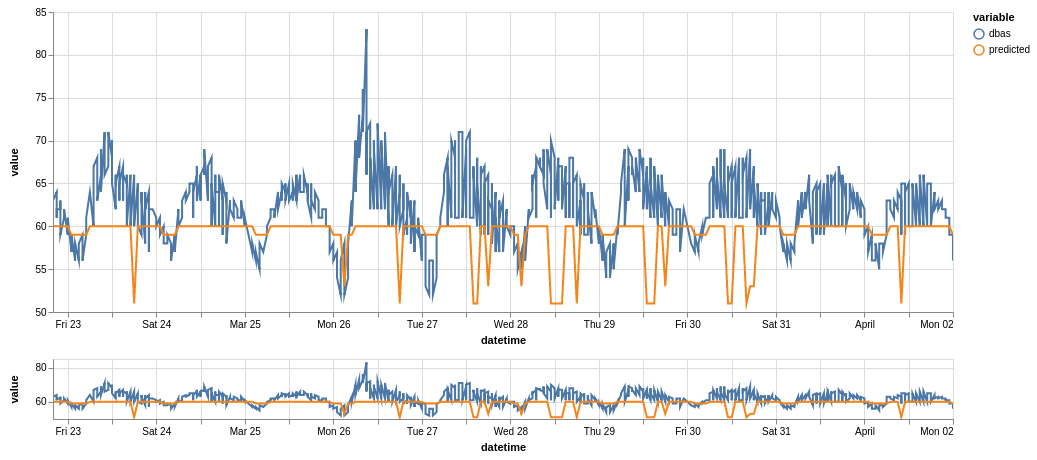

In [176]:
## defining kernels
kernel_classifier = 1.0 * RBF(1.0)

## defining precessors
gp_classifier = GaussianProcessClassifier(kernel=kernel_classifier, random_state=0)

## spliting into features and results
X = location_dataframe[['taxi', 'wind', 'noise', 'precipitation', 'hour_sin', 'hour_cos']]
y = location_dataframe[['dbas']].astype(int)

## splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Training
gp_classifier.fit(X_train, y_train)

## Calculating Error
y_pred = gp_classifier.predict(X_test)
error_df = binDistance(y_test, y_pred)

## Plotting timeseries
plot_timeseries(error_df[['dbas', 'predicted']], 'test title')

In [177]:
y_pred_prob = gp_classifier.predict_proba(X_test)

In [191]:
y_pred_prob.shape

(620, 28)

In [180]:
error_df['predicted'].unique()

array([60, 59, 51, 53])

In [188]:
y_test['dbas'].unique().max() - y_test['dbas'].unique().min()

31

## Gaussian Regressor

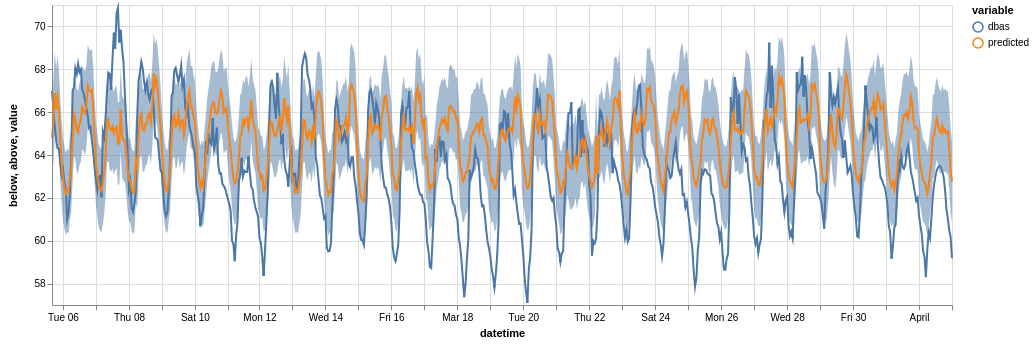

In [275]:
## defining kernel
kernel_regressor = DotProduct() + WhiteKernel()

## defining regressor
gp_regressor = GaussianProcessRegressor(kernel=kernel_regressor,random_state=0)

## spliting into features and results
X = location_dataframe[['taxi', 'wind', 'noise', 'precipitation', 'hour_sin', 'hour_cos']]
y = location_dataframe[['dbas']]

## splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## Training
gp_regressor.fit(X_train, y_train)

## Calculating Error
y_pred, pred_std = gp_regressor.predict(X_test, return_std=True)
error_df = binDistance(y_test, y_pred)
error_df['std_dev'] = pred_std

error_df['below'] = error_df['predicted'] - error_df['std_dev']
error_df['above'] = error_df['predicted'] + error_df['std_dev']

## Plotting timeseries
plot_timeseries(error_df[['dbas', 'predicted']], error_df[['below', 'above']], 'test title')

## Merging data for the test location

In [287]:
timeseries.keys()

dict_keys([113, 114, 79, 234, 236, 162, 100, 161, 233, 144, 42])

In [306]:
location_dataframe_test = pd.DataFrame()
test_coords = []
region = 233

for sensor in timeseries[region]:    
    
    current_df = timeseries[region][sensor]['dataframe'].dropna(subset=['dbas'])
    current_df['noise'].fillna(0, inplace=True)
    location_dataframe_test = location_dataframe_test.append(current_df)
    test_coords.append(getSensorCoords(sensor))

    
## sorting the dataframe
# location_dataframe_test = location_dataframe_test.sort_values(by='datetime', ascending=True)
location_dataframe_test = location_dataframe_test.groupby(['datetime']).mean()
# location_dataframe_test.set_index('datetime', inplace=True)

## Plotting location
folium_map = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
plotLocation(folium_map, taxi_regions[taxi_regions['LocationID'] == region])
plotSensors(folium_map, test_coords)

display(folium_map)

In [307]:
X_loctest = location_dataframe_test[['taxi', 'wind', 'noise', 'precipitation', 'hour_sin', 'hour_cos']]
y_loctest = location_dataframe_test[['dbas']]

y_pred_loctest, pred_std_loctest = gp_regressor.predict(X_loctest, return_std=True)

error_df_loctest = binDistance(y_loctest, y_pred_loctest)
print(error_df_loctest['error'].mean())

error_df_loctest['std_dev'] = pred_std_loctest

error_df_loctest['below'] = error_df_loctest['predicted'] - error_df_loctest['std_dev']
error_df_loctest['above'] = error_df_loctest['predicted'] + error_df_loctest['std_dev']

6.7950031283179415


In [313]:
error_df_loctest['std_dev'].max()

1.9836702781210396

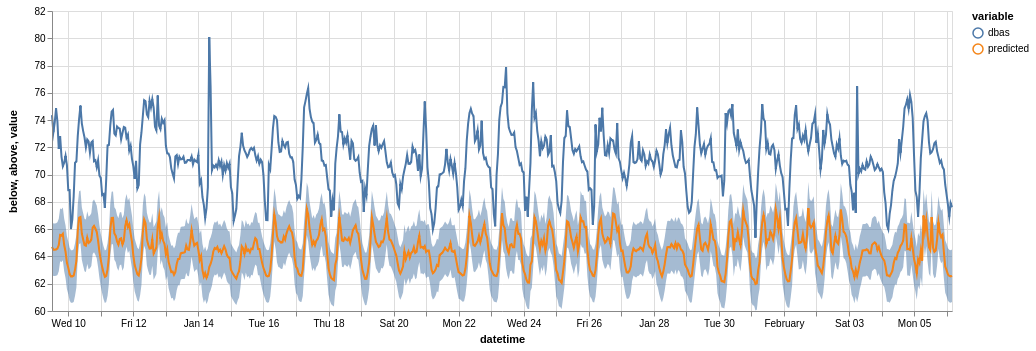

In [309]:
# alt.data_transformers.enable('default', max_rows=None)
plot_timeseries(error_df_loctest[['dbas', 'predicted']], error_df_loctest[['below', 'above']], 'test title')

## Helper Functions

### Geospatial Functions

In [82]:
def spatialJoin(sensorLat, sensorLon, sensorID, geoDataFrame):
    
    d = 200 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(sensorLon, sensorLat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon, 'sensorID':sensorID}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataFrame, sinpoly, how='inner', op="within")
    
    return dataframe

### Processing Functions

In [103]:
def binDistance(y_test, y_pred):
    
    y_test['predicted'] = y_pred
    y_test['error'] = abs(y_test['dbas'] - y_test['predicted']) 
    
    return y_test

def getSensorCoords(sensorID):
    
    sensorPoint = None
    
    f = open(sensors_file)
    for line in f:
        
        s, lat, lon = line.split(' ')
        lat = float(lat)
        lon = float(lon)
        
        if(s == sensorID):
            sensorPoint = shapely.geometry.Point(lon, lat)
            break
            
    f.close()
    return sensorPoint

### Visualization Functions

In [283]:
def plot_timeseries(pred_timeseries, error_band, title):
    
#     tranforming to long form
    long_form_df = pd.melt(pred_timeseries.reset_index(), id_vars=['datetime'])

#     brush = alt.selection(type='interval', encodings=['x'])

#     line = alt.Chart(long_form_df).mark_line().encode(
#         alt.X('datetime', type='temporal', scale={'domain': brush.ref()}),
#         alt.Y('value', type='quantitative', scale=alt.Scale(zero=False)),
#         color='variable'
#     ).properties(
#         width=900
#     )

    line = alt.Chart(long_form_df).mark_line().encode(
        alt.X('datetime', type='temporal'),
        alt.Y('value', type='quantitative', scale=alt.Scale(zero=False)),
        color='variable'
    ).properties(width=900)

#     print(pred_timeseries)
    
    # Configure the confidence interval        
    confidence_interval = alt.Chart(error_band.reset_index()).mark_area(opacity=0.5).encode(
        x='datetime:T',
        y='below:Q',
        y2='above:Q').properties(width=900)
    
#     lower = line.properties(
#         height=60
#     ).add_selection(brush)

    upper = confidence_interval + line
#     display(alt.vconcat(upper, lower))
    display(upper)
    

def plot_timeseries_scatter(pred_timeseries, error_band, title):
    
#     long_form_df = pd.melt(pred_timeseries.reset_index(), id_vars=['datetime'])
    
    line = alt.Chart(pred_timeseries.reset_index()).mark_line(color='yellow').encode(
        alt.X('datetime', type='temporal'),
        alt.Y('predicted', type='quantitative', scale=alt.Scale(zero=False))
    ).properties(width=900)
    
    scatter = alt.Chart(pred_timeseries.reset_index()).mark_circle(size=10, color='red').encode(
        alt.X('datetime', type='temporal'),
        alt.Y('dbas', type='quantitative', scale=alt.Scale(zero=False))).properties(width=900)
    
        # Configure the confidence interval        
    confidence_interval = alt.Chart(error_band.reset_index()).mark_area(opacity=0.9).encode(
        x='datetime:T',
        y='below:Q',
        y2='above:Q').properties(width=900)
    
    upper = confidence_interval + scatter + line
#     display(alt.vconcat(upper, lower))
    display(upper)
    
def plotLocation(folium_map, geodf):
    folium.GeoJson(geodf,style_function=lambda feature: {'color' : 'red'}).add_to(folium_map)

def plotSensors(folium_map, sensor_coords):
    for coord in sensor_coords:
        folium.Marker([coord.y, coord.x]).add_to(folium_map)